In [24]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [25]:
tf.random.set_seed(42)
np.random.seed(42)

In [26]:
url = "https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv"
data = pd.read_csv(url)

In [27]:
data = data.dropna()

In [28]:
data = pd.get_dummies(data, columns=['ocean_proximity'], drop_first=True)

In [29]:
X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

In [30]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [32]:
X_train = tf.constant(X_train, dtype=tf.float32)
X_test = tf.constant(X_test, dtype=tf.float32)
y_train = tf.constant(y_train, dtype=tf.float32)
y_test = tf.constant(y_test, dtype=tf.float32)

In [33]:
def weighted_mse_loss(y_true, y_pred):
    sorted_y = tf.sort(y_true)
    n = tf.shape(sorted_y)[0]
    mid = n // 2
    median = tf.cond(
        tf.math.mod(n, 2) == 0,
        lambda: (sorted_y[mid-1] + sorted_y[mid]) / 2.0,
        lambda: sorted_y[mid]
    )
    weights = tf.where(y_true > median, 2.0, 1.0)
    squared_error = tf.square(y_true - y_pred)
    weighted_error = squared_error * weights
    return tf.reduce_mean(weighted_error)

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1)
])

In [35]:
model.compile(optimizer='adam', loss=weighted_mse_loss, metrics=['mse'])

In [36]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10


409/409 [==============================] - 21s 26ms/step - loss: 98980331520.0000 - mse: 55820984320.0000 - val_loss: 99505086464.0000 - val_mse: 56370794496.0000
Epoch 2/10
409/409 [==============================] - 7s 18ms/step - loss: 99451797504.0000 - mse: 55782985728.0000 - val_loss: 99401179136.0000 - val_mse: 56310370304.0000
Epoch 3/10
409/409 [==============================] - 8s 18ms/step - loss: 98804547584.0000 - mse: 55701188608.0000 - val_loss: 99229032448.0000 - val_mse: 56210452480.0000
Epoch 4/10
409/409 [==============================] - 8s 20ms/step - loss: 98714648576.0000 - mse: 55583330304.0000 - val_loss: 98999590912.0000 - val_mse: 56077402112.0000
Epoch 5/10
409/409 [==============================] - 8s 20ms/step - loss: 98786713600.0000 - mse: 55433744384.0000 - val_loss: 98718154752.0000 - val_mse: 55914192896.0000
Epoch 6/10
409/409 [==============================] - 8s 19ms/step - loss: 98122924032.0000 - mse: 55255756800.0000 - val_loss: 9839

In [37]:
y_pred = model.predict(X_test)
y_pred = y_pred.flatten()
y_test_np = y_test.numpy()

128/128 [==============================] - 2s 12ms/step


In [38]:
standard_mse = mean_squared_error(y_test_np, y_pred)

In [39]:
custom_loss = weighted_mse_loss(y_test, tf.constant(y_pred, dtype=tf.float32)).numpy()

In [40]:
results = pd.DataFrame({
    'Loss Type': ['Custom Weighted MSE', 'Standard MSE'],
    'Value': [custom_loss, standard_mse]
})

In [41]:
print("\nLoss Comparison Table:")
print(results)


Loss Comparison Table:
             Loss Type         Value
0  Custom Weighted MSE  1.029055e+11
1         Standard MSE  5.513429e+10


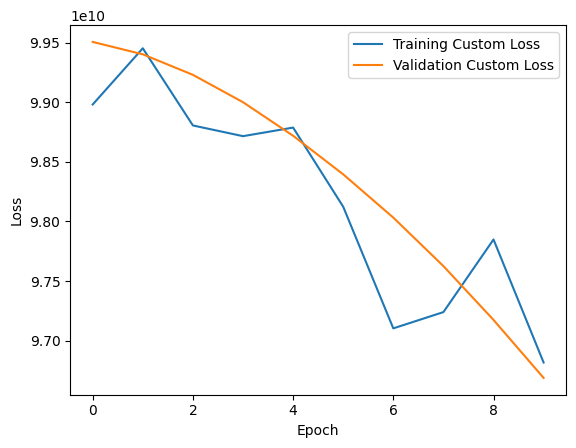

In [42]:
plt.plot(history.history['loss'], label='Training Custom Loss')
plt.plot(history.history['val_loss'], label='Validation Custom Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()